In [1]:
import os
import json

import numpy as np

from datetime import date, datetime, timedelta
import matplotlib.pyplot as plt

In [2]:
from src.jump import Jump
from pso import *

In [3]:
BEG_OF_TIME = '2016-06-01'
END_OF_TIME = '2020-09-30'

In [4]:
def get_asset_returns(asset):
    """
    get complete return time serie for an asset
    """
    returns = []

    prev_date = datetime.strptime(BEG_OF_TIME, '%Y-%m-%d').date() - timedelta(days=1)
    prev_value = 0.0

    for i, values in enumerate(asset["values"]):
        current_date = datetime.strptime(values["date"], '%Y-%m-%d').date()

        nb_days = (current_date - prev_date).days
        diff = (values["return"] - prev_value) / nb_days

        for i in range(nb_days - 1):
            returns.append(prev_value)
        returns.append(values["return"])

        prev_value = values["return"]
        prev_date = current_date

    return returns

In [5]:
def plot_history(history):
    plt.plot(history)
    plt.ylabel('fitness')
    plt.xlabel('iteration')
    plt.title('Evolution of fitnesss')
    plt.show()

## Preprocessing

In [6]:
asset_dict, portfolio_id = Jump().get_all_assets("assets_cache.json")

keys = list(asset_dict.keys())
assets = list(asset_dict.values())

returns_list = []

for _, asset in asset_dict.items():
    returns = get_asset_returns(asset)
    returns_list.append(returns)

returns_list = np.array(returns_list)
mean_returns = np.mean(returns_list, axis=1)

returns_covariance = np.cov(returns_list)

## Run PSO

In [7]:
PSO = ParticleSwarmOptimizer(
    population_size=100,
    hyperparameters=PSOHyperparameters(
        inertia = 0.09,
        inertia_dampening = 0.99,
        cognitive_acceleration = 1.0,
        social_acceleration = 1.0,
    ),
    constraints=PSOConstraints(
        n_var = len(asset_dict),
        var_min = 0.00,
        var_max = 0.10,
    ),
    values=mean_returns,
    covariance_matrix=returns_covariance,
)

In [8]:
best_particle, history = PSO.run(1000)

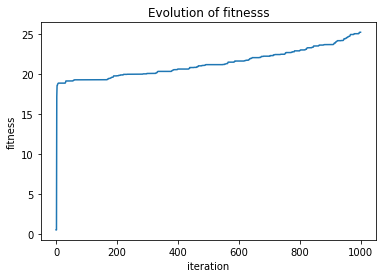

In [9]:
plot_history(history)